In [1]:
from header import *
plt.rcParams.update({'font.size': 14})

In [2]:
df_seeds = read_astarix_performance('results/ecoli_illumina250_astar-seeds.tsv')
df_base = read_astarix_performance('results/ecoli_illumina250_astar-prefix.tsv')

df_seeds = read_astarix_performance('results/MHC1-astarix-prefix/alignments.tsv')
df_base = read_astarix_performance('results/MHC1-astarix-seeds/alignments.tsv')

display(df_seeds.head())

,ref,refsize,algo,operation,memory,len,read,spell,cost,starts,pushed,popped,repeat_rate,t(map),t(astar),unique_best,pushed+popped,explored_states
readname,,,,,,,,,,,,,,,,,,
simulated.81,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,ATCACATCCAAATCTCACAGGCCTCAAAAGCTACAGCTGACATTCC...,ATCACATCCAAATCTCACAGGCCTCAAAAGCTACAGCTGACATTCC...,0,-1,1.42,0.15,0.0,0.020333,0.000959,1,1.57,142.0
simulated.82,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,AGAAAAGTACCTCAAAAGGACAAATCTAAGAATGATTGGTGCTCAA...,AGAAAAGTACCTCAAAAGGACAAATCTAAGAATGATTGGTGCTCAA...,0,-1,1.51,0.16,0.0,0.020695,0.017829,1,1.67,151.0
simulated.83,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,ATGAGAACACATGGACACAGGAAGGGGAACATCACACTCTGGGGAC...,ATGAGAACACATGGACACAGGAAGGGGAACATCACACTCTGGGGAC...,0,-1,4.41,0.54,0.0,0.079559,0.002115,1,4.95,441.0
simulated.84,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,TAAAGAAATGTGACTCAGTGGTCCACATGGTTGCAGTACCTCCCAT...,TAAAGAAATGTGACTCAGTGGTCCACATGGTTGCAGTACCTCCCAT...,0,-1,2.74,0.23,0.0,0.040670,0.001997,1,2.97,274.0
simulated.85,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,CATTACTCAGGACAACAGAAGAGAAAGAGCAGGTCTAGAGTGTATA...,CATTACTCAGGACAACAGAAGAGAAAGAGCAGGTCTAGAGTGTATA...,0,-1,1.30,0.15,0.0,0.020289,0.000950,1,1.45,130.0


In [3]:
def cross_validation(seeds, base):
    correct = True
    for index, row in df_seeds.iterrows():
        #display(row)
        a = df_base[df_base['read'] == row['read']]
        assert(len(a) == 1)
        r = a.iloc[0]
        if row.cost != r.cost:
            print("Mismatching costs: ", row.cost, " != ", r.cost)
            print(row)
            print(r)
            correct = False
    print('Checked ' + str(len(df_seeds)) + ' alignments.')
    return correct

In [4]:
cross_validation(df_seeds, df_base)

Checked 100 alignments.


True

In [255]:
def read_maf(fn):
    L = []
    loc = -1
    readname = 'empty'
    for line in open(fn, 'r').readlines():
        arr = line.split()
        if len(arr) == 0:
            continue
        if arr[0] == 'a':
            loc = -1
            readname = 'empty'
            continue
        if arr[1] == 'ref':
            loc  = int(arr[2])
        else:
            readname = arr[1]
            L.append([readname, loc])
    df = pd.DataFrame(L, columns=['readname', 'gt_loc'])
    df.set_index('readname', inplace=True)
    return df

In [260]:
def compare_eq(df, col1='minimap_loc', col2='gt_loc'):
    eq, diff = 0, 0
    for index, row in df.iterrows():
        if abs(row[col1]-row[col2]) < 1000:
            eq += 1
        else:
            #print("Mistake: ", index, row[col1], row[col2])
            diff += 1
    print('Checked ' + str(len(df)) + ' alignments:')
    print(col1 + ' overlaps with ' + col2 + ' in:', eq)
    print('differs in: {} ({:.3}%)'.format(diff, 100.0*diff/(eq+diff)))

In [261]:
def str2errors(s):
    n, errors = 0, 0
    for c in s:
        if c >= '0' and c <= '9':
            n = n*10 + int(c)
        else:
            if c == 'S' or c == 'D' or c == 'I':
                errors += n
            else:
                assert(c == 'M')
            n = 0
    return errors

In [328]:
def check_minimap(minimap_sam_fn, gt_maf_fn):
    print(minimap_sam_fn)
    print(gt_maf_fn)
    
    df_minimap = pd.read_csv(minimap_sam_fn, skiprows=2, header=None, delim_whitespace=True, index_col=0, usecols=[0,1,2,3,4,5,6,7,8,9,10])
    #df_minimap = df_minimap.set_index(0, verify_integrity=True)
#    df_minimap['minimap_nm_cost'] = [ int(x.split(':')[2]) for x in df_minimap[10] ]
#    df_minimap['minimap_str_cost'] = [ str2errors(s) for s in df_minimap[4] ]
    df_minimap['minimap_loc'] = [ int(x) if x != '*' else -100000 for x in df_minimap[2] ]
    df_minimap['query_len'] = [ len(s) for s in df_minimap[8] ]
    
    #df_seeds = read_astarix_performance('results/ecoli_head1000000_linear_long_300_ccs/astar-default/alignments.tsv')
 #   print(df_minimap.head())
    
    df_gt = read_maf(gt_maf_fn)
    
#    df = df_seeds.join(df_minimap, sort=True)
    df = df_minimap.join(df_gt, sort=True)
    df['is_correct'] = [ abs(r['minimap_loc'] - r['gt_loc']) < 1000 for idx, r in df.iterrows() ]
    compare_eq(df, 'minimap_loc', 'gt_loc')
    ax = df['query_len'].plot.hist(bins=30, alpha=0.5)
    
    ###
    h = {}
    d = 50
    for i in range(0,1000,d):
        h[i] = (1.0 * sum([ r['is_correct'] for idx, r in df.iterrows() if r['query_len'] >= i and r['query_len'] < i+d ]) / (1+sum([ 1 for idx, r in df.iterrows() if r['query_len'] >= i and r['query_len'] < i+d ])))
    c = pd.DataFrame(list(h.items()), columns = ['len', '% correct alignments'])
    print(c)
    c.plot('len', '% correct alignments')
    #plt.savefig('plots'/(prefix+'_'+x+'-'+y+'.png'), bbox_inches='tight')
    #draw_plot(df, 'query_len', 'is_correct')

results/ecoli_head1000000_linear_long_clr/minimap.sam
results/ecoli_head1000000_linear_long_clr/gt/sd_0001.maf
Checked 6575 alignments:
minimap_loc overlaps with gt_loc in: 6462
differs in: 113 (1.72%)
    len  % correct alignments
0     0              0.000000
1    50              0.000000
2   100              0.000000
3   150              0.000000
4   200              0.500000
5   250              0.000000
6   300              0.800000
7   350              0.875000
8   400              0.909091
9   450              0.904762
10  500              0.954545
11  550              0.961538
12  600              0.969697
13  650              0.980392
14  700              0.979592
15  750              0.982759
16  800              0.982143
17  850              0.985075
18  900              0.987342
19  950              0.987179


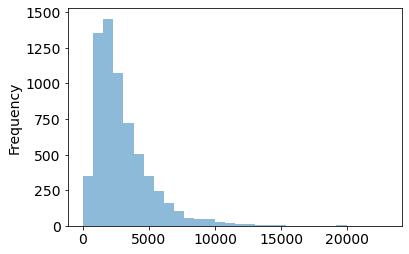

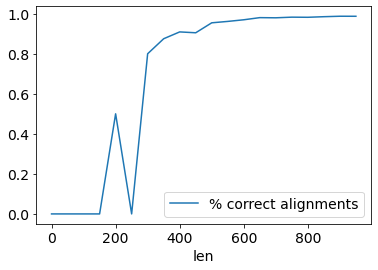

In [329]:
check_minimap('results/ecoli_head1000000_linear_long_clr/minimap.sam', 'results/ecoli_head1000000_linear_long_clr/gt/sd_0001.maf')

results/ecoli_head1000000_linear_long_ccs/minimap.sam
results/ecoli_head1000000_linear_long_ccs/gt/sd_0001.maf
Checked 109171 alignments:
minimap_loc overlaps with gt_loc in: 108710
differs in: 461 (0.422%)
108710
   len  % correct alignments
0    0              0.000000
1  100              0.993956
2  200              0.994438
3  300              0.994891
4  400              0.995659
5  500              0.997077
6  600              0.997068
7  700              0.997196
8  800              0.998261
9  900              0.999093


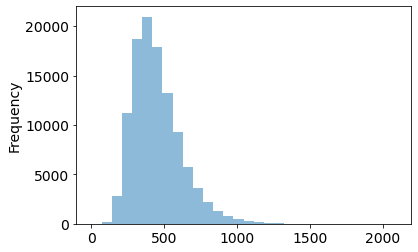

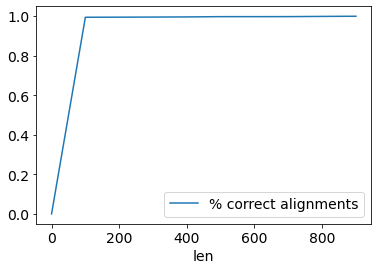

In [325]:
check_minimap('results/ecoli_head1000000_linear_long_ccs/minimap.sam', 'results/ecoli_head1000000_linear_long_ccs/gt/sd_0001.maf')

In [215]:
check_minimap('results/ecoli_head1000000_linear_long_500_clr/minimap2/aln.sam', 'results/ecoli_head1000000_linear_long_500_clr/gt/sd_0001.maf')

results/ecoli_head1000000_linear_long_500_clr/minimap2/aln.sam
results/ecoli_head1000000_linear_long_500_clr/gt/sd_0001.maf
           1       2   3                                                  4  5  6  7                                                  8                                                  9       10  minimap_loc  query_len  gt_loc
0                                                                                                                                                                                                                                  
S1_1       0  497903  12  18S7M1I9M1I4M1I23M1I3M1I9M2I12M1D10M1D12M1I16M...  *  0  0  AAAGCAACGACTTTAAAGTCAGAAATTCTCAGGCCGGGATCATTCA...  -"*#$(&'../.&*))%*'"&'+&(&(*)".,#-#+*'&-&+#*#*...  NM:i:86       497903        500  497891
S1_10     16  842002  50  8S9M1D3M2I8M1I7M1D2M1D5M2I21M1I11M1I37M2I5M1I2...  *  0  0  TGCCGTCTTGAGAGAGATCCGGGCTCAGGACCGGTGGCATAGTAGG...  ('!-+,$'#'(.,*-,.'')$.%(("(**,',(.&(++.-&..#*)...  NM:i

In [206]:
check_minimap('results/ecoli_head1000000_linear_long_300_ccs/minimap2/aln.sam', 'results/ecoli_head1000000_linear_long_300_ccs/long_300_ccs/sd_0001.maf')

results/ecoli_head1000000_linear_long_300_ccs/minimap2/aln.sam
results/ecoli_head1000000_linear_long_300_ccs/long_300_ccs/sd_0001.maf
Checked 78571 alignments:
minimap_loc overlaps with gt_loc in: 78085
differs in: 486 (0.619%)


In [195]:
## NOT USED
def compare_costs(df, col1='cost_seeds', col2='cost_minimap'):
    eq, seeds_better, minimap_better = 0, 0, 0
    
    for index, row in df.iterrows():
        #display(row)
        #print(index, row[col1], row[col2])
        if row[col1] == row[col2]:
            eq += 1
        elif row[col1] < row[col2]:
            seeds_better += 1
        elif row[col1] > row[col2]:
            #assert(False)
            #print('!!!')
            minimap_better += 1
        else:
            print("Mistake")
            assert(False)
    print('Checked ' + str(len(df)) + ' alignments:')
    print(col1 + ' better in:', seeds_better)
    print(col2 + ' minimap better in:', minimap_better)
    print('            Equal in:', eq)

In [192]:
compare_eq(df, 'minimap_loc', 'gt_loc')
#compare_costs(df, 'cost', 'minimap_str_cost')

Checked 100 alignments:
minimap_loc overlaps with gt_loc in: 99


ValueError: cannot switch from automatic field numbering to manual field specification

In [287]:
def draw_plot(df, colx, coly):
    ax = df.plot(colx, coly)


In [288]:
draw_plot(df, 'query_len', 'is_correct')

KeyError: 'query_len'